In [1]:
import pandas as pd
from datetime import datetime

In [2]:
csv_path_launch_ts = "job_launch_ts.csv"
df_launch = pd.read_csv(csv_path_launch_ts).fillna("")
df_launch.sample(2)

,run_name,launch_time
49,time-to-train_1b-llama-tok-v4-256-d071ac5b-0714,2024-07-14 12:55:37 PM PDT
6,time-to-train_1b-llama-tok-v5litepod-256-aca5f...,2024-07-13 07:57:21 PM PDT


In [3]:
csv_path_jobs = "wandb_runs_time-to-train.csv"
df_jobs = pd.read_csv(csv_path_jobs)
# rename total_time to total_job_time
df_jobs = df_jobs.rename(columns={"total_time": "total_job_time"})
df_jobs.sample(2)

,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu
12,time-to-train_1b-llama-tok-v4-256-76a93f33-0714,18.412399,28.380000,17.656705,2024-07-14 13:29:24 PDT,2024-07-15 17:52:12 PDT,meta-llama/Llama-2-7b-hf,1024,479.457282,29762,1204881408,128,46.826634
9,time-to-train_1b-llama-tok-v5litepod-256-86c58...,7.665289,28.846944,6.466668,2024-07-14 13:46:21 PDT,2024-07-15 18:37:10 PDT,meta-llama/Llama-2-7b-hf,1024,757.443115,17220,1204881408,256,NaN


In [4]:
df = pd.merge(df_jobs, df_launch, on="run_name", how="left").fillna("")
df.sample(4)

,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu,launch_time
0,time-to-train_1b-llama-tok-v5litepod-256-c129b...,4.700332,11.607500,0.750516,2024-07-15 07:00:53 PDT,2024-07-15 18:37:20 PDT,meta-llama/Llama-2-7b-hf,1024,757.618277,1999,1204881408,256,,2024-07-14 05:49:37 PM PDT
3,time-to-train_1b-llama-tok-v5litepod-256-ac84c...,13.265140,23.658889,6.605833,2024-07-14 18:13:45 PDT,2024-07-15 17:53:17 PDT,meta-llama/Llama-2-7b-hf,1024,757.504281,17592,1204881408,256,,2024-07-14 05:45:35 PM PDT
23,time-to-train_1b-llama-tok-v4-256-136ae5f8-0713,18.652437,45.209167,17.204430,2024-07-13 21:24:39 PDT,2024-07-15 18:37:12 PDT,meta-llama/Llama-2-7b-hf,1024,479.446550,28999,1204881408,128,46.802112,2024-07-13 08:17:18 PM PDT
1,time-to-train_1b-llama-tok-v5litepod-256-7b519...,7.759312,13.106944,4.692722,2024-07-15 05:30:54 PDT,2024-07-15 18:37:19 PDT,meta-llama/Llama-2-7b-hf,1024,757.613888,12499,1204881408,256,,2024-07-14 05:46:32 PM PDT


In [5]:
from dateutil import parser



def get_total_time_from_launch(launch_time_str: str, end_time_str: str) -> float:
    if not launch_time_str or not end_time_str:
        return 
    
    launch_time = parser.parse(launch_time_str)
    end_time = parser.parse(end_time_str)
    diff = end_time - launch_time
    diff_seconds = diff.total_seconds()
    diff_hrs = diff_seconds / 3600.0
    return diff_hrs

df["total_time_from_launch"] = df.apply(lambda row: get_total_time_from_launch(row["launch_time"], row["heartbeat_time"]), axis=1)

/home/shared/miniconda3/envs/ivan/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [6]:
df["tpu_type"] = df["run_name"].apply(lambda x: "v4-256" if "v4" in x else "v5lite-256")

In [7]:
"""
I have a dataframe with the following columns:
- launch_time: the time a job is launched
- create_time: the time when a cluster is allocated for the job
- heartbeat_time: the last time a job is active
- tpu_type: the type of the TPU that the job is using/going to use

I want to create a function that, for each row, calculates that 
by the time the job is launched, how many clusters of the same tpu_type
are actively running. 

Think thought this problem step-by-step, then write the function
"""

import pandas as pd

def count_active_clusters(df):
    def parse_date(date_str):
        if not date_str:
            return ""
        if isinstance(date_str, datetime):
            return date_str
        return parser.parse(date_str)

    for col in ['launch_time', 'heartbeat_time', 'create_time']:
        df[col] = df[col].apply(parse_date)
    
    # Initialize a list to store the counts
    active_cluster_counts = []
    
    for _, row in df.iterrows():
        tpu_type = row['tpu_type']
        create_time = row["create_time"]
        
        # Count active clusters of the same tpu_type at launch_time
        count = sum(
            (df["tpu_type"] == row['tpu_type']) & 
            (df["heartbeat_time"] > create_time) & (df["create_time"] < create_time)
        )
        active_cluster_counts.append(count)

    df['active_clusters_at_create'] = active_cluster_counts
    
    return df

# Usage:
# df = pd.read_csv('your_data.csv')  # Load your dataframe
# df_with_counts = count_active_clusters(df)


df = count_active_clusters(df)

/home/shared/miniconda3/envs/ivan/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [8]:
def get_time_to_launch(row):
    if "total_time_from_launch" not in row:
        return ""
    return row["total_time_from_launch"] - row["total_job_time"]

df["time_to_create_cluster"] = df.apply(get_time_to_launch, axis=1)

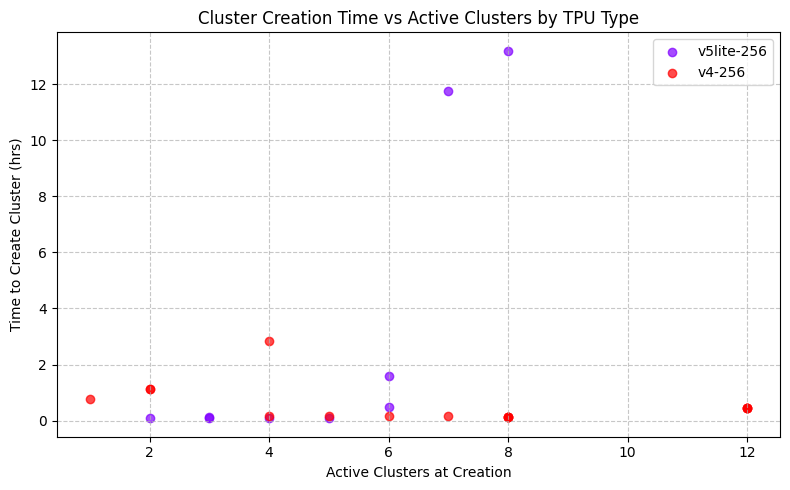

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
plt.figure(figsize=(8, 5))

# Get unique TPU types for color assignment
tpu_types = df['tpu_type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(tpu_types)))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df['tpu_type'] == tpu_type
    plt.scatter(df.loc[mask, 'active_clusters_at_create'], 
                df.loc[mask, 'time_to_create_cluster'],
                c=[color], 
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('Active Clusters at Creation')
plt.ylabel('Time to Create Cluster (hrs)')
plt.title('Cluster Creation Time vs Active Clusters by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

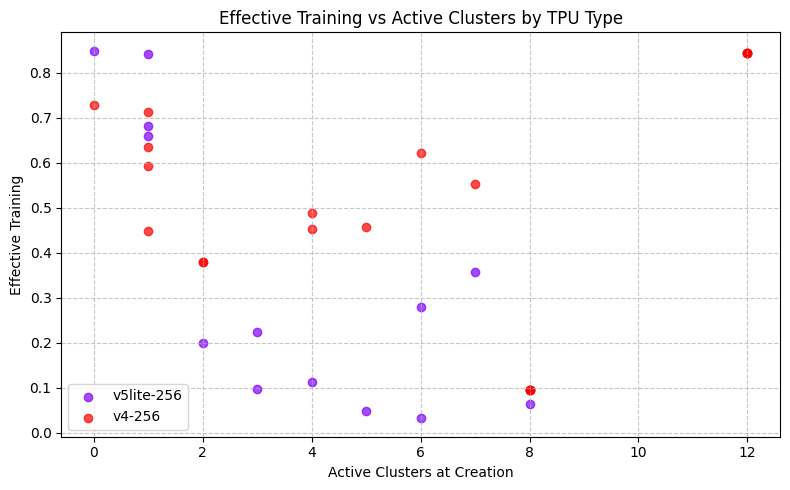

In [10]:
df["effective_training"] = df["training_time"] / df["total_job_time"]

# Create a scatter plot
plt.figure(figsize=(8, 5))

# Get unique TPU types for color assignment
tpu_types = df['tpu_type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(tpu_types)))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df['tpu_type'] == tpu_type
    plt.scatter(df.loc[mask, 'active_clusters_at_create'], 
                df.loc[mask, 'effective_training'],
                c=[color], 
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('Active Clusters at Creation')
plt.ylabel('Effective Training')
plt.title('Effective Training vs Active Clusters by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
def get_time_to_1t(row):
    seq_len = 4096
    target = 1000000000000.0
    train_batch_size = row["train_batch_size"]
    global_step = row["global_step"]
    total_job_time = row["total_job_time"]
    total_steps = target / seq_len / train_batch_size
    time_to_train = total_steps / global_step * total_job_time
    return time_to_train


df["time_to_train_1T"] = df.apply(get_time_to_1t, axis=1)

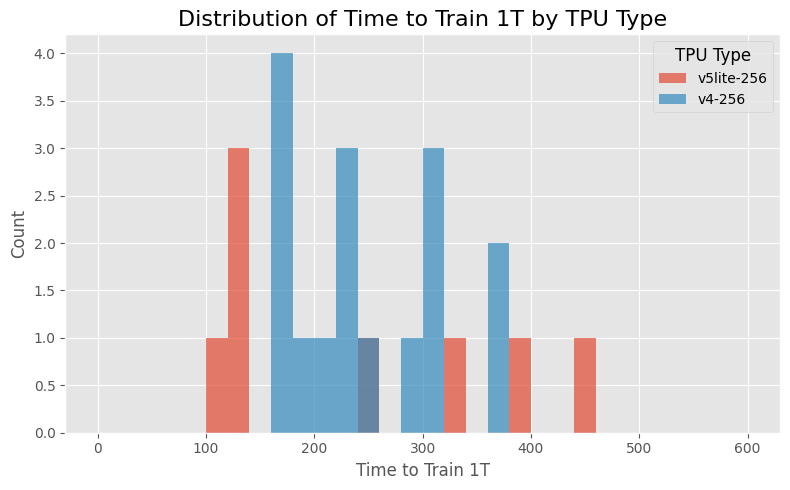

In [12]:
# Assuming you have your data in a DataFrame called 'df'
# If not, you'll need to load your data first
# df = pd.read_csv('your_data.csv')

# Set the style for better-looking plots
plt.style.use('ggplot')

# Get unique TPU types
tpu_types = df['tpu_type'].unique()

# Create the histogram
plt.figure(figsize=(8, 5))

for tpu_type in tpu_types:
    subset = df[df['tpu_type'] == tpu_type]
    plt.hist(subset['time_to_train_1T'], bins=30, range=(0, 600), alpha=0.7, label=tpu_type)

# Customize the plot
plt.title('Distribution of Time to Train 1T by TPU Type', fontsize=16)
plt.xlabel('Time to Train 1T', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add a legend
plt.legend(title='TPU Type', title_fontsize='12', fontsize='10')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
df.to_csv("wandb_runs_with_launch_ts.csv", index=False)